In [127]:
# Import necessary libraries
import pandas as pd
import numpy as np
import db_utils, sqlalchemy
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
import math
import os
import gzip
import re
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
import time
from collections import Counter
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
#bbox_to_anchor =(1.0, 1.0)
import requests
save_path= '/Users/johgeist/Documents/AG_Luck/3did_project/revisions/revision_figures/'

In [84]:
# Function to fetch the experimental method used for structure determination of a given 3D structure from the PDB
# using the RCSB PDB API
def get_experiment_method(pdb_id):
    # Base URL for the PDB API
    base_url = 'https://data.rcsb.org/rest/v1/core/entry/'

    # URL for fetching metadata of the given PDB ID
    url = base_url + pdb_id
    
    # Fetch metadata from the PDB API
    response = requests.get(url)
    response
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract experimental method information
        experimental_method = data['rcsb_entry_info']['experimental_method'] if pdb_id.upper() in data['entry']['id'] else None
        return experimental_method
    else:
        # Print an error message if the request was not successful
        print("Error fetching data from the PDB API.")
        return None
    
# Function to fetch the resolution of a given 3D structure from the PDB using the RCSB PDB API
def get_resolution(pdb_id):
    # Base URL for the PDB API
    base_url = 'https://data.rcsb.org/rest/v1/core/entry/'

    # URL for fetching metadata of the given PDB ID
    url = base_url + pdb_id

    # Fetch metadata from the PDB API
    response = requests.get(url)
    response
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract experimental method information
        if 'resolution_combined' in data['rcsb_entry_info']:
            resolution = data['rcsb_entry_info']['resolution_combined'] if pdb_id.upper() in data['entry']['id'] else None
            return resolution
        else:
            return [np.nan]
    else:
        # Print an error message if the request was not successful
        print("Error fetching data from the PDB API.")
        return None

# Function to create custom autopunct for plotting
def make_autopct(data):
    def my_autopct(pct):
        total = sum(data)
        val = int(round(pct*total/100.0))
        if val/total < 0.01:
            return ' '
        else:
            return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct


In [86]:
# Load in the manual curation set to derive a list of 3D structures to check for each DDI type in the set
df_mc = pd.read_csv('/Users/johgeist/Downloads/DDI_curation table_wihtout_homo_protein_structures_4.csv')
df_mc = df_mc[~df_mc['DDI_type'].str.contains('curation')]
df_mc['PDB_ID'] = df_mc['PDB_ID'].str.lower()

In [87]:
df_mc_grouped = df_mc.groupby('DDI_type').agg({'PDB_ID': list})
df_mc_grouped.reset_index(inplace=True)

In [88]:
df_mc_grouped

,DDI_type,PDB_ID
0,PF00004_PF10584,[6epf]
1,PF00009_PF01873,[2d74]
2,PF00010_PF02344,"[6g6l, 1nkp]"
3,PF00019_PF00041,[4ui2]
4,PF00023_PF07686,[4nik]
5,PF00023_PF09067,[6moh]
6,PF00026_PF06394,[1f34]
7,PF00059_PF00041,[1tdq]
8,PF00089_PF00095,[1fle]
9,PF00137_PF07850,[6vqg]


In [108]:
# Use the previously created function to fetch the experimental method as well as the overall structural resolution
# for each 3D structure in the manual curation set
methods_all = []
methods_single = []
resolution_all = []
resolution_single = []
PDB_IDs = []
for index, row in df_mc_grouped.iterrows():
    methods = []
    resolutions = []
    DDI_type = row['DDI_type']
    for PDB_ID in row['PDB_ID']:
        print(PDB_ID)
        PDB_IDs.append(PDB_ID)
        resolution = get_resolution(PDB_ID)[0]
        method= get_experiment_method(PDB_ID)
        methods_single.append(method)
        resolution_single.append(resolution)
        methods.append(method)
        resolutions.append(resolution)
    methods_all.append(methods)
    resolution_all.append(resolutions)

6epf
2d74
6g6l
1nkp
4ui2
4nik
6moh
1f34
1tdq
1fle
6vqg
3egg
7jtk
3axy
5vyw
4kfz
2y3a
3tx7
5g5x
1nf3
1pp9
7cgp
5f0l
7cft
1l0v
3ve1
1n5w
1zxi
6qum
6sh6
6jp6
6q2n
4gs7
1ul1
1dev
3wjm
3hhs
4y66
6jwp
6tt7
6zbb
5c3i
5zbb
2v92
1w1w
5c3l
6f40
6zr2
6c0f
2fyl
5vj1
7aav
6omf
3zkj
6zvh
6ka7
6fqb
6gs2
2gsk
1g4b
6eu0
6cnf
4khb
6fur
3vxq
6rpb
6g2j
6zka
5ool
6h9u
5anr
6gfx
4ajy
6id1
6g90
3t6g
2fja
1jnr
2ka6
6mzf
3ixe
3fmp
5gqq
5l4k
3zni
5ool
3j7y
6d6q
6id0
6zym
4khb
6upk
3l4f
3kz1
2x19


In [109]:
# Add the results to the df_mc_grouped dataframe
df_mc_grouped['method']= methods_all
df_mc_grouped['resolution']= resolution_all

In [110]:
# Change display settings to show all rows
pd.set_option('display.max_rows', None)

In [111]:
df_mc_grouped

,DDI_type,PDB_ID,method,resolution
0,PF00004_PF10584,[6epf],[EM],[11.8]
1,PF00009_PF01873,[2d74],[X-ray],[2.8]
2,PF00010_PF02344,"[6g6l, 1nkp]","[X-ray, X-ray]","[2.2, 1.8]"
3,PF00019_PF00041,[4ui2],[X-ray],[3.15]
4,PF00023_PF07686,[4nik],[X-ray],[2.5]
5,PF00023_PF09067,[6moh],[X-ray],[3.2]
6,PF00026_PF06394,[1f34],[X-ray],[2.45]
7,PF00059_PF00041,[1tdq],[X-ray],[2.6]
8,PF00089_PF00095,[1fle],[X-ray],[1.9]
9,PF00137_PF07850,[6vqg],[EM],[4.2]


In [112]:
df_method_resolution = pd.DataFrame()

In [113]:
# Create a new dataframe holding the determination method and structural resolution for each structure
# (not condensed per DDI type)
df_method_resolution['PDB_ID']= PDB_IDs
df_method_resolution['method']= methods_single
df_method_resolution['resolution']= resolution_single

In [114]:
df_method_resolution

,PDB_ID,method,resolution
0,6epf,EM,11.800
1,2d74,X-ray,2.800
2,6g6l,X-ray,2.200
3,1nkp,X-ray,1.800
4,4ui2,X-ray,3.150
5,4nik,X-ray,2.500
6,6moh,X-ray,3.200
7,1f34,X-ray,2.450
8,1tdq,X-ray,2.600
9,1fle,X-ray,1.900


In [119]:
df_method_resolution['resolution'].max() ## min= 1.5 ; max = 11.8 ; ~96% < 5,

11.8

In [123]:
len(df_method_resolution[df_method_resolution['resolution']<= 5])/95

0.9578947368421052

<Figure size 7680x5760 with 0 Axes>

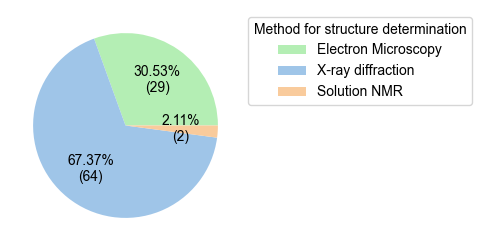

In [131]:
# Pie chart for the distribution of mehtos used for structure determination in the manual curation set
my_pal = ['#b4eeb4', '#9fc5e8', '#f9cb9c'] #, '#ea9999', '#ffd966']

data = [len(df_method_resolution[df_method_resolution['method']== 'EM']), len(df_method_resolution[df_method_resolution['method']== 'X-ray']),
       len(df_method_resolution[df_method_resolution['method']== 'NMR'])]
labels= ['Electron Microscopy', 'X-ray diffraction', 'Solution NMR']

my_autopct= make_autopct(data)
plt.figure(dpi=1200) 
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(data, colors = my_pal, textprops={'fontsize': 10}, autopct= my_autopct) #, wedgeprops=dict(edgecolor='black')
ax.legend(labels= labels, bbox_to_anchor=(1, 1), title= 'Method for structure determination', ncol=1)
#plt.savefig(f'{save_path}methods_for_structure_determination.pdf', transparent=True, bbox_inches='tight')
plt.show()